# Computer Vision CSCI-GA.2272-001 Assignment 1, part 2.

Fall 2021 semester.

Due date: **September 30th 2021.**

## Introduction
This assignment requires you to participate in a Kaggle competition with the rest of the class on the The German Traffic Sign Recognition Benchmark [http://benchmark.ini.rub.de/?section=gtsrb&subsection=news]. The objective is to produce a model that gives the highest possible accuracy on the test portion of this dataset. You can register for the competition using the private link: https://www.kaggle.com/c/nyu-computer-vision-csci-ga2271-2021/overview.

Skeleton code is provided in the colab below. This contains code for training a simple default model and evaluating it on the test set. The evaluation script produces a file gtsrb_kaggle.csv that lists the IDs of the test set images, along with their predicted label. This file should be uploaded to the Kaggle webpage, which will then produce a test accuracy score. 

Your goal is to implement a new model architecture that improves upon the baseline performance. You are free to implement any approach covered in class or from research papers. This part will count for 50% of the overall grade for assignment 1. This Grading will depend on your Kaggle performance and rank, as well as novelty of the architecture.  

## Rules
You should make a copy of this Colab (File->Save a copy in Drive). Please start the assignment early and don’t be afraid to ask for help from either the TAs or myself. You are allowed to collaborate with other students in terms discussing ideas and possible solutions. However you code up the solution yourself, i.e. you must write your own code. Copying your friends code and just changing all the names of the variables is not allowed! You are not allowed to use solutions from similar assignments in courses from other institutions, or those found elsewhere on the web.
Your solutions should be submitted via the Brightspace system. This should include a brief description (in the Colab) explaining the model architectures you explored, citing any relevant papers or techniques that you used. You should also include convergence plots of training accuracy vs epoch for relevant models. 

### Important Details
• You are only allowed eight (8) submissions to the Kaggle evaluation server per day. This is to prevent over-fitting on the test dataset. So be sure to start the assignment early!

• You are NOT ALLOWED to use the test set labels during training in any way. Doing so will be regarded as cheating and penalized accordingly.

• The evaluation metric is accuracy, i.e. the fraction of test set examples where the predicted label agrees with the ground truth label.

• You should be able to achieve a test accuracy of at least 0.95. 

• *Extra important:* Please use your NYU NetID as your Kaggle username, so the TAs can figure out which user you are on the leaderboard. 


# Dataset Preparation


1.  Download `dataset.zip` from to your local machine.
2.  Unzip the file. You should see a `dataset` directory with three subfolders (`training,validation,testing`). 
3.  Go to Google Drive (on your NYU account) and make a directory `assign2_dataset` (New button --> New Folder).
4.  Upload each of the three subfolders to it (New button --> Folder upload). 
5.  Run the code block below. It will ask for permission to mount your Google Drive (NYU account) so this colab can access it. Paste the authorization code into the box as requested. 


In [77]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/assign2_dataset/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/assign2_dataset


# Dataloader

In [78]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

batch_size = 64
momentum = 0.9
lr = 0.0001
epochs = 15
log_interval = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class MyDataset(Dataset):

    def __init__(self, X_path="X.pt", y_path="y.pt"):

        self.X = torch.load(X_path).squeeze(1)
        self.y = torch.load(y_path).squeeze(1)
    
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_path="train/X.pt", y_path="train/y.pt")
val_dataset = MyDataset(X_path="validation/X.pt", y_path="validation/y.pt")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [79]:
# import matplotlib.pyplot as plt
# import numpy as np

# def matplotlib_imshow(img, one_channel=False):
#     if one_channel:
#         img = img.mean(dim=0)
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     if one_channel:
#         plt.imshow(npimg, cmap="Greys")
#     else:
#         plt.imshow(np.transpose(npimg, (1, 2, 0)))

# for idx in range(20):
#   matplotlib_imshow(train_dataset[idx][0])
#   print(idx, train_dataset[idx][1])

# idx = 12
# matplotlib_imshow(train_dataset[idx][0])
# print(idx, train_dataset[idx][1])

# Model

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 50, kernel_size=5)
        self.conv2 = nn.Conv2d(50, 200, kernel_size=5)
        self.conv3 = nn.Conv2d(200, 500, kernel_size=5)
        self.batch_norm1 = nn.BatchNorm2d(50)
        self.batch_norm2 = nn.BatchNorm2d(200)
        self.batch_norm3 = nn.BatchNorm2d(500)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, nclasses)

    def forward(self, x):
        # print(f"Input Shape: {x.shape}")
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.batch_norm1(x)
        # print(f"Conv1 Output Shape: {x.shape}")
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.batch_norm2(x)
        # print(f"Conv2 Output Shape: {x.shape}")
        x = F.relu(self.conv3(x))
        x = self.batch_norm3(x)
        # print(f"Conv3 Output Shape: {x.shape}")
        x = x.view(-1, 500)
        # print(f"Reshape: {x.shape}")
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)


# Training

In [81]:
model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

def train(epoch):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    training_accuracy = 100*correct/len(train_loader.dataset)
    print(f"Training accuracy: {training_accuracy}")
    return training_accuracy
    

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))

train_accuracy_points = []
for epoch in range(1, epochs + 1):
    train_accuracy_points.append(train(epoch))
    validation()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')


Train Epoch: 1 [0/35339 (0%)]	Loss: 3.779272
Train Epoch: 1 [640/35339 (2%)]	Loss: 3.659363
Train Epoch: 1 [1280/35339 (4%)]	Loss: 3.585432
Train Epoch: 1 [1920/35339 (5%)]	Loss: 3.276061
Train Epoch: 1 [2560/35339 (7%)]	Loss: 3.410810
Train Epoch: 1 [3200/35339 (9%)]	Loss: 3.220715
Train Epoch: 1 [3840/35339 (11%)]	Loss: 3.059530
Train Epoch: 1 [4480/35339 (13%)]	Loss: 2.988729
Train Epoch: 1 [5120/35339 (14%)]	Loss: 3.003740
Train Epoch: 1 [5760/35339 (16%)]	Loss: 3.041141
Train Epoch: 1 [6400/35339 (18%)]	Loss: 2.994274
Train Epoch: 1 [7040/35339 (20%)]	Loss: 2.856915
Train Epoch: 1 [7680/35339 (22%)]	Loss: 2.900438
Train Epoch: 1 [8320/35339 (24%)]	Loss: 2.404506
Train Epoch: 1 [8960/35339 (25%)]	Loss: 2.355125
Train Epoch: 1 [9600/35339 (27%)]	Loss: 2.362021
Train Epoch: 1 [10240/35339 (29%)]	Loss: 2.321698
Train Epoch: 1 [10880/35339 (31%)]	Loss: 2.521634
Train Epoch: 1 [11520/35339 (33%)]	Loss: 2.304737
Train Epoch: 1 [12160/35339 (34%)]	Loss: 2.061462
Train Epoch: 1 [12800/3533

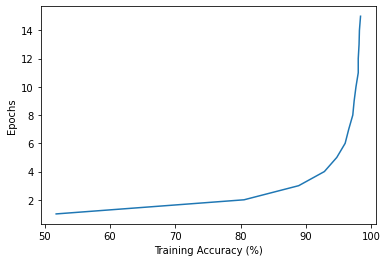

In [82]:
from matplotlib import pyplot as plt
x = train_accuracy_points
y = list(range(1, epochs + 1))
plt.xlabel("Training Accuracy (%)")
plt.ylabel("Epochs")
plt.plot(x, y)
plt.show()

# Evaluate and Submit to Kaggle



In [83]:


import pickle
import pandas as pd

outfile = 'gtsrb_kaggle.csv'

output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}

test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))
model = Net() # TODO: load your model here, don't forget to put it on Eval mode !
model.load_state_dict(torch.load("model_15.pth"))
model.eval()

for i, data in enumerate(test_data):
    data = data.unsqueeze(0)
    output = model(data)
    pred = output.data.max(1, keepdim=True)[1].item()
    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(pred)

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

Written to csv file gtsrb_kaggle.csv


# Submitting to Kaggle

Now take this csv file, download it from your Google drive and then submit it to Kaggle to check performance of your model.

# Summary of research
In order to get a decent starting performance, I looked up some articles regarding construction and optimization of CNNs. The general intuition I developed for building CNNs was that:
- Convolutions help capture and focus on spatial dependencies of a image, unlike normal neural networks
- Pooling is a convenient, yet, effective tool for dimensionality reduction and in general, max-pooling works better than average-pooling.

## Initial Performance
Based on the above assumptions and a rudimentary idea of a convnet, the initial network achieved ~65% accuracy on validation set. Given the low accuracy, and based on the multiple layers of convolutions often observed on popular and highly performant networks like VGGNet and AlexNet, I made the following changes
- Added another convolution with max-pooling
- Increased out-channels on each convolution layer
- Increased features on FC layers

## Improved Performance
I observed a significant jump to ~88% accuracy on the validation set, althought the training accuracy seemed much higher, indicating overfitting. I also noticed that the training speed was too low, so based on my read-ups regarding batch size and learning rate, I decided to:
- Switching from SGD to Adam optimizer to handle overshooting due to high learning rate.
- Switching over to cross entropy loss.
- Increase batch size from 32 to 64 to improve generalization (thereby mitigating overfitting) and increase training speed.
- Decreased learning rate from 0.01 to 0.0001
- Increase Epochs from 10 to 15.

## Final Performance and Analysis
After the abovementioned changes, I was able to achieve ~97% accuracy on the test data. However, I noticed that there was a significant gap between training and validation accuracy (average of ~5%). In order to push the performance further and reduce this gap, I:
- Attempted to add dropout to another convolution layer in order to increase generalization.
- Added more FC layers to increase depth.
- Reduced batch size to 32 and increased learning rate to counter possible variance.

## Future Ideas
- Image augmentation.
- Regularization using weight decay
- CutMix
- KFold Cross Validation

## References
- [Comprehensive Guide to CNN](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)
- https://medium.com/@dipti.rohan.pawar/improving-performance-of-convolutional-neural-network-2ecfe0207de7
- [CNN Architectures](https://medium.com/analytics-vidhya/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5)